# Проект Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Его нужно изучить, прежде чем генерировать новые признаки.

**Описание процесса обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов

## imports

In [1]:
!pip install psycopg2-binary inflection

In [2]:
from sqlalchemy import create_engine, MetaData, inspect
import inflection

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 220724

## db config

In [4]:
db_config = {
'user': 'user',
'pwd': 'pwd',
'host': 'host',
'port': 0000,
'db': 'db'
}

In [5]:
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)
inspector = inspect(engine)

## Исследование db

In [6]:
schema_name = 'steel'
table_names = inspector.get_table_names(schema=schema_name)
print("Таблицы в схеме 'steel':", table_names)

Таблицы в схеме 'steel': ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']


In [7]:
table_info = []
with engine.connect() as connection:
    for table_name in table_names:
        print(f"Обработка таблицы: {table_name}")
        try:
            count_result = connection.execute(f"SELECT COUNT(*) FROM {schema_name}.{table_name}")
            count = count_result.scalar()

            columns = inspector.get_columns(table_name, schema=schema_name)
            num_columns = len(columns)

            size_query = f"SELECT pg_size_pretty(pg_total_relation_size('{schema_name}.{table_name}')) AS size;"
            size_result = connection.execute(size_query)
            size = size_result.fetchone()[0]

            table_info.append({
                'Table Name': table_name,
                'Number of Entries': count,
                'Number of Columns': num_columns,
                'Size': size
            })
        except Exception as e:
            print(f"Ошибка при обработке таблицы {table_name}: {e}")


Обработка таблицы: data_arc
Обработка таблицы: data_bulk
Обработка таблицы: data_bulk_time
Обработка таблицы: data_gas
Обработка таблицы: data_temp
Обработка таблицы: data_wire
Обработка таблицы: data_wire_time


In [8]:
df_info = pd.DataFrame(table_info)
df_info

,Table Name,Number of Entries,Number of Columns,Size
0,data_arc,14876,5,1152 kB
1,data_bulk,3129,16,232 kB
2,data_bulk_time,3129,16,256 kB
3,data_gas,3239,2,184 kB
4,data_temp,15907,3,832 kB
5,data_wire,3081,10,208 kB
6,data_wire_time,3081,10,200 kB


Сверим информацию с предоставленным описанием:

**Таблица steel.data_arc**
* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.

**Таблица steel.data_bulk**
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.

**Таблица steel.data_bulk_time**
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.

**Таблица steel.data_gas**
* key — номер партии;
* gas — объём подаваемого газа.

**Таблица steel.data_temp**
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.

**Таблица steel.data_wire**
* key — номер партии;
* Wire1 … Wire9 — объём подаваемых проволочных материалов.

**Таблица steel.data_wire_time**
* key — номер партии;
* Wire1 … Wire9 — время подачи проволочных материалов.

Количество таблиц и столбцов в них соответствует описанию. Загрузим все таблицы и переведем названия столбцов в snake_case

In [9]:
def load_table(table_name, schema_name='steel'):
    query = f"SELECT * FROM {schema_name}.{table_name}"
    with engine.connect() as conn:
        return pd.read_sql(query, conn.connection)

In [10]:
def convert_columns_to_snake_case(df):
    df.columns = [inflection.underscore(col) for col in df.columns]
    return df

In [11]:
data_arc = load_table('data_arc')
data_bulk = load_table('data_bulk')
data_bulk_time = load_table('data_bulk_time')
data_gas = load_table('data_gas')
data_temp = load_table('data_temp')
data_wire = load_table('data_wire')
data_wire_time = load_table('data_wire_time')

In [12]:
data_arc = convert_columns_to_snake_case(data_arc)
data_bulk = convert_columns_to_snake_case(data_bulk)
data_bulk_time = convert_columns_to_snake_case(data_bulk_time)
data_gas = convert_columns_to_snake_case(data_gas)
data_temp = convert_columns_to_snake_case(data_temp)
data_wire = convert_columns_to_snake_case(data_wire)
data_wire_time = convert_columns_to_snake_case(data_wire_time)

## Исследовательский анализ и предобработка данных

### data_arc

In [13]:
display(data_arc.info(), data_arc.describe(), data_arc.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   begin_heat      14876 non-null  object 
 2   end_heat        14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,begin_heat,end_heat,active_power,reactive_power
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


In [14]:
missing_values = data_arc.isnull().sum()
duplicates = data_arc.duplicated().sum()
print("Пропущенные значения в данных:\n", missing_values)
print("Количество дубликатов в данных:", duplicates)

Пропущенные значения в данных:
 key               0
begin_heat        0
end_heat          0
active_power      0
reactive_power    0
dtype: int64
Количество дубликатов в данных: 0


Как видим, партии нагревают не сразу, а в несколько итераций. Интересно посмотреть, постоянно ли значение итераций.

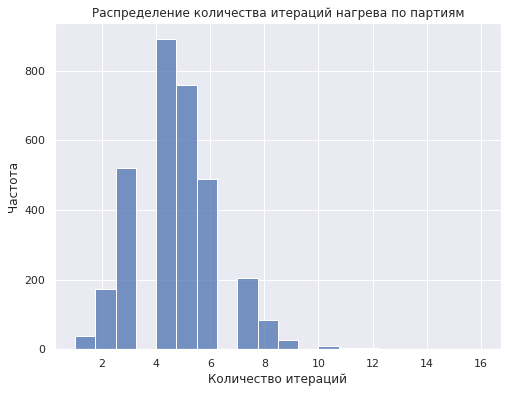

In [15]:
iteration_counts = data_arc['key'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.histplot(iteration_counts, bins=20, kde=False)
plt.title('Распределение количества итераций нагрева по партиям')
plt.xlabel('Количество итераций')
plt.ylabel('Частота')
plt.show()

Значение непостоянно, самое частое значение - 5

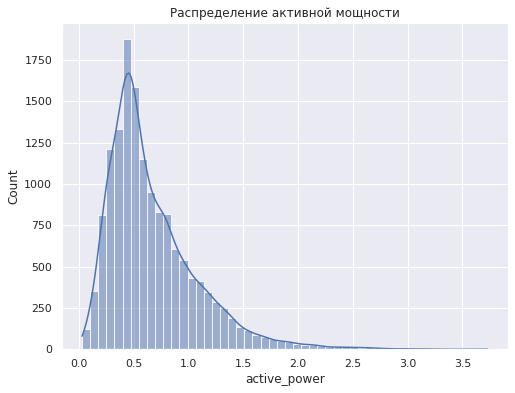

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(data_arc['active_power'], bins=50, kde=True)
plt.title('Распределение активной мощности')
plt.show()

Красивое правдоподобное распределение.

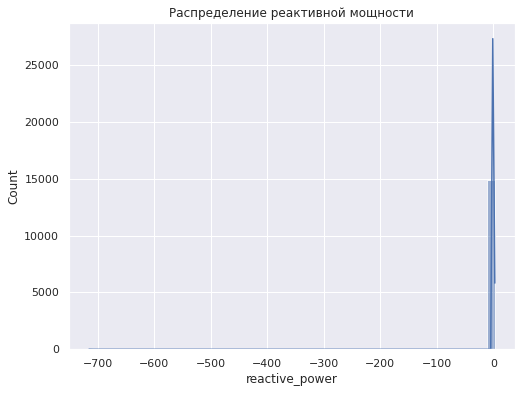

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(data_arc['reactive_power'], bins=50, kde=True)
plt.title('Распределение реактивной мощности')
plt.show()

Тут происходит что-то плохое. 

In [18]:
data_arc.sort_values(by = ['reactive_power']).head()

,key,begin_heat,end_heat,active_power,reactive_power
9781,2116,00:44:48,00:46:37,0.495782,-715.504924
5597,1216,08:22:19,08:22:30,0.030188,0.020806
2420,521,17:42:57,17:43:11,0.030563,0.021154
4915,1060,04:31:57,04:32:08,0.031630,0.022485
4634,1000,01:17:44,01:17:57,0.038186,0.022983


Как мы видели раньше, в таблице есть отрицательная reactive power, что [теоретически возможно](https://aperc.gov.in/admin/upload/151340198613587660935a34ae822cf4c.pdf). Но здесь негативное значение -715 явно является выбросом. Посмотрим подробнее на эту партию.

In [19]:
data_arc[data_arc['key'] == 2116]

,key,begin_heat,end_heat,active_power,reactive_power
9779,2116,00:29:52,00:31:54,0.433266,0.306141
9780,2116,00:35:50,00:38:05,0.620265,0.408352
9781,2116,00:44:48,00:46:37,0.495782,-715.504924
9782,2116,00:51:51,00:52:58,0.299368,0.198796


Это значение можно бы было заменить на среднее, медиану или что-то вроде того, но это финальный проект, и можно побыть fancy и провести регрессионный анализ (точек конечно не очень много, но мне кажется это лучше чем брать какое-то другое значение)

In [20]:
selected_keys = [2116]
filtered_data = data_arc[data_arc['key'].isin(selected_keys)]

In [21]:
filtered_data_no_outliers = filtered_data[filtered_data['reactive_power'] > -715]

In [22]:
X = filtered_data_no_outliers[['active_power']]
y = filtered_data_no_outliers['reactive_power']
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [23]:
anomalous_value = filtered_data[(filtered_data['key'] == 2116) & (filtered_data['reactive_power'] < -700)]
predicted_value = model.predict(anomalous_value[['active_power']])

In [24]:
predicted_value[0]

0.33339199071070097

In [25]:
intercept = model.intercept_
slope = model.coef_[0]

formula = f"reactive_power = {intercept:.4f} + {slope:.4f} * active_power"

print("Формула линейной регрессии для партии 2116:")
print(formula)

Формула линейной регрессии для партии 2116:
reactive_power = 0.0130 + 0.6463 * active_power


In [26]:
data_arc.loc[(data_arc['key'] == 2116) & (data_arc['reactive_power'] < -700), 'reactive_power'] = predicted_value
data_arc[data_arc['key'] == 2116]

,key,begin_heat,end_heat,active_power,reactive_power
9779,2116,00:29:52,00:31:54,0.433266,0.306141
9780,2116,00:35:50,00:38:05,0.620265,0.408352
9781,2116,00:44:48,00:46:37,0.495782,0.333392
9782,2116,00:51:51,00:52:58,0.299368,0.198796


Снова взглянем на график reactive_power

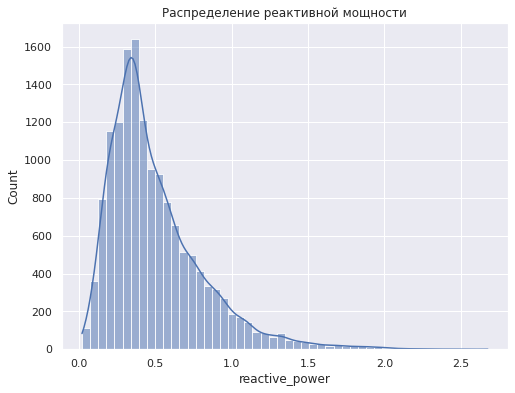

In [27]:
plt.figure(figsize=(8, 6))
sns.histplot(data_arc['reactive_power'], bins=50, kde=True)
plt.title('Распределение реактивной мощности')
plt.show()

Выглядит более правдоподобно и консистентно с active_power.

Дальше заказчик предлагает создать новые признаки, которые могут пригодиться в обучении. Так и сделаем.

In [28]:
data_arc['begin_heat'] = pd.to_datetime(data_arc['begin_heat'], format='%H:%M:%S').dt.time
data_arc['end_heat'] = pd.to_datetime(data_arc['end_heat'], format='%H:%M:%S').dt.time

In [29]:
def calculate_duration(row):
    begin_time = pd.to_datetime(row['begin_heat'], format='%H:%M:%S')
    end_time = pd.to_datetime(row['end_heat'], format='%H:%M:%S')
    
    if end_time < begin_time:
        end_time += pd.Timedelta(days=1)
    
    duration = (end_time - begin_time).total_seconds()
    return duration

In [30]:
data_arc['arc_duration'] = data_arc.apply(calculate_duration, axis=1)
data_arc['total_power'] = data_arc['active_power'] + data_arc['reactive_power']
data_arc['apparent_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)
data_arc['power_ratio'] = data_arc['active_power'] / (data_arc['reactive_power'] + 1e-10)  # на 0 не делим
data_arc['heating_count'] = data_arc.groupby('key')['key'].transform('count')

In [31]:
aggregated_data_arc = data_arc.groupby('key').agg({
    'arc_duration': 'mean',  # Средняя длительность нагрева
    'apparent_power' : 'mean', # Среднее значение общей мощности
    'power_ratio': 'mean',  # Среднее значение соотношения мощности
    'heating_count': 'max'  # Количество запусков нагрева
}).reset_index()

In [32]:
aggregated_data_arc.head()

,key,arc_duration,apparent_power,power_ratio,heating_count
0,1,219.60,1.165279,1.538898,5
1,2,202.75,0.912304,1.551834,4
2,3,131.00,0.597907,1.583120,5
3,4,185.25,0.953741,1.563487,4
4,5,217.25,1.008939,1.480428,4


### data_bulk

In [34]:
display(data_bulk.info(), data_bulk.describe(), data_bulk.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk 1   252 non-null    float64
 2   bulk 2   22 non-null     float64
 3   bulk 3   1298 non-null   float64
 4   bulk 4   1014 non-null   float64
 5   bulk 5   77 non-null     float64
 6   bulk 6   576 non-null    float64
 7   bulk 7   25 non-null     float64
 8   bulk 8   1 non-null      float64
 9   bulk 9   19 non-null     float64
 10  bulk 10  176 non-null    float64
 11  bulk 11  177 non-null    float64
 12  bulk 12  2450 non-null   float64
 13  bulk 13  18 non-null     float64
 14  bulk 14  2806 non-null   float64
 15  bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Как видим, многие материалы являются очень редкими для добавления, и использованы меньше чем 100 раз за все время. Но данные могут быть релевантны, пока не буду ничего редактировать, кроме замены NaN на 0.

In [35]:
data_bulk.fillna(0, inplace=True)

Теперь можно посмотреть на данные в более удобоваримом виде, на графике.

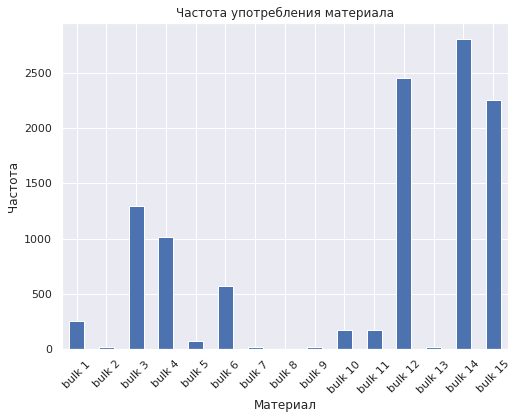

In [36]:
material_usage = data_bulk.loc[:, data_bulk.columns != 'key'].astype(bool).sum()

plt.figure(figsize=(8, 6))
material_usage.plot(kind='bar')
plt.xlabel('Материал')
plt.ylabel('Частота')
plt.title('Частота употребления материала')
plt.xticks(rotation=45)
plt.show()


### data_bulk_time

In [37]:
display(data_bulk_time.info(), data_bulk_time.describe(), data_bulk_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk 1   252 non-null    object
 2   bulk 2   22 non-null     object
 3   bulk 3   1298 non-null   object
 4   bulk 4   1014 non-null   object
 5   bulk 5   77 non-null     object
 6   bulk 6   576 non-null    object
 7   bulk 7   25 non-null     object
 8   bulk 8   1 non-null      object
 9   bulk 9   19 non-null     object
 10  bulk 10  176 non-null    object
 11  bulk 11  177 non-null    object
 12  bulk 12  2450 non-null   object
 13  bulk 13  18 non-null     object
 14  bulk 14  2806 non-null   object
 15  bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


Как видим пропуски полностью соответствуют предыдущей таблице, что свидетельствует что вещество не добавлялось.

In [38]:
bulk_columns = [col for col in data_bulk_time.columns if 'bulk' in col]
data_bulk_time[bulk_columns].describe()

,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,252,22,1288,1009,77,576,25,1,19,176,177,2407,18,2760,2213
top,04:50:32,08:36:19,17:23:09,09:26:47,08:36:19,01:04:57,17:34:38,17:46:11,13:54:18,03:05:53,06:18:45,05:49:32,23:34:05,05:49:32,05:49:32
freq,1,1,2,2,1,1,1,1,1,1,1,3,1,3,3


Как видим измерения адекватные, ничего не измеряется сутками, но я пока не очень понимаю как использовать эти данные.

### data_gas

In [39]:
display(data_gas.info(), data_gas.describe(), data_gas.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Пропусков нет. Посмотрим на распределение.

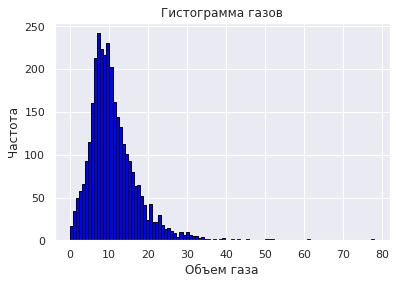

In [40]:
plt.hist(data_gas['gas'], bins=100, color='blue', edgecolor='black')
plt.title('Гистограмма газов')
plt.xlabel('Объем газа')
plt.ylabel('Частота')
plt.show()

Как видим максимальное встречающееся значение примерно в 7 раз выше, чем среднее. Я не обладаю экспертными знаниями, но мне кажется такое имеет место быть. Оставим как есть.

### data_temp

In [41]:
display(data_temp.info(), data_temp.describe(), data_temp.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   mesaure_time  15907 non-null  object 
 2   temperature   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,mesaure_time,temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


In [42]:
data_temp = data_temp.rename(columns={'mesaure_time': 'measure_time'})

Это таблица с нашим целевым признаком - последней температурой партии. Начальную температуру можно использовать как признак. Промежуточные значения используемые как признак приведут к лику таргета, предупреждает закачик. При агрегировании нужно использовать только партии, у которых минимум 2 наблюдения. Значения ниже 1500 градусов - аномальные.

In [43]:
last_measurements = data_temp.groupby('key').tail(1)

In [44]:
last_measurements.isna().sum()

key               0
measure_time      0
temperature     739
dtype: int64

In [45]:
keys_with_missing_last_measurement = last_measurements[last_measurements['temperature'].isna()]['key']

In [46]:
data_temp_cleaned = data_temp[~data_temp['key'].isin(keys_with_missing_last_measurement)]

Для 739 партий таргета вообще нет. Это очень много данных, но сделать ничего нельзя. Их придется удалить. Теперь агрегируем данные по партиям

In [47]:
data_temp_cleaned = data_temp_cleaned.groupby('key').filter(lambda x: len(x) >= 2)
data_temp_cleaned['measure_time'] = pd.to_datetime(data_temp_cleaned['measure_time'], format='%H:%M:%S')

In [48]:
aggregated_data_temp = data_temp_cleaned.groupby('key').agg(
    initial_temperature=('temperature', 'first'),
    final_temperature=('temperature', 'last'),
    time_delta=('measure_time', lambda x: (x.max() - x.min()).total_seconds())
).reset_index()

Теперь можно посмотреть на аномалии.

In [49]:
anomalies = aggregated_data_temp[(aggregated_data_temp['initial_temperature'] < 1500) | (aggregated_data_temp['final_temperature'] < 1500)]
print("Anomalies (temperatures below 1500):")
anomalies

Anomalies (temperatures below 1500):


,key,initial_temperature,final_temperature,time_delta
853,867,1191.0,1599.0,2177.0
1199,1214,1208.0,1591.0,2565.0
1602,1619,1218.0,1590.0,1080.0
2034,2052,1227.0,1592.0,1946.0


С такими партиями попрощаемся.

In [50]:
aggregated_data_temp = aggregated_data_temp[~aggregated_data_temp['key'].isin(anomalies['key'])]

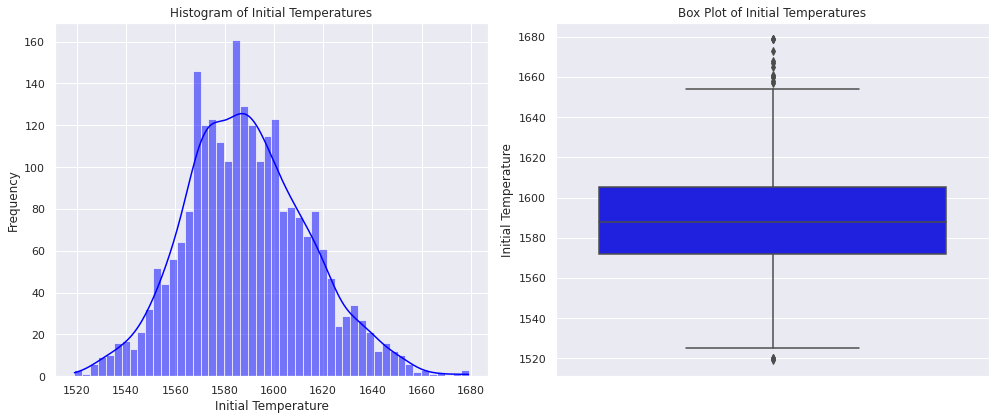

In [51]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(aggregated_data_temp['initial_temperature'], bins=50, kde=True, color='blue')
plt.title('Histogram of Initial Temperatures')
plt.xlabel('Initial Temperature')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=aggregated_data_temp['initial_temperature'], color='blue')
plt.title('Box Plot of Initial Temperatures')
plt.ylabel('Initial Temperature')

plt.tight_layout()
plt.show()

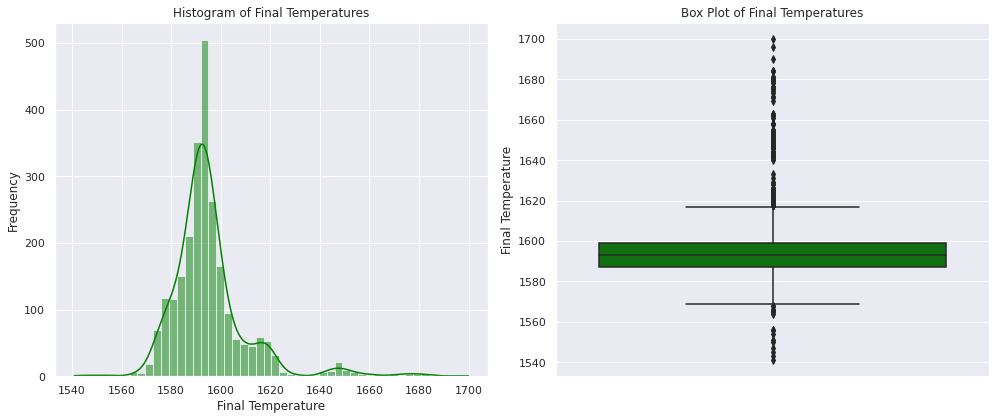

In [52]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(aggregated_data_temp['final_temperature'], bins=50, kde=True, color='green')
plt.title('Histogram of Final Temperatures')
plt.xlabel('Final Temperature')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=aggregated_data_temp['final_temperature'], color='green')
plt.title('Box Plot of Final Temperatures')
plt.ylabel('Final Temperature')

plt.tight_layout()
plt.show()

In [53]:
aggregated_data_temp.describe()

,key,initial_temperature,final_temperature,time_delta
count,2471.000000,2471.000000,2471.000000,2471.000000
mean,1250.484015,1589.012950,1595.339943,3640.401052
std,720.109488,25.004369,16.035215,12225.405643
min,1.000000,1519.000000,1541.000000,234.000000
25%,628.500000,1572.000000,1587.000000,1186.500000
50%,1252.000000,1588.000000,1593.000000,1613.000000
75%,1872.500000,1605.000000,1599.000000,2284.500000
max,2499.000000,1679.000000,1700.000000,86192.000000


Все выглядит хорошо. Финальные температуры выше начальных, аномально выбивающихся значений нет.

### data_wire

In [54]:
display(data_wire.info(), data_wire.describe(), data_wire.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire 1  3055 non-null   float64
 2   wire 2  1079 non-null   float64
 3   wire 3  63 non-null     float64
 4   wire 4  14 non-null     float64
 5   wire 5  1 non-null      float64
 6   wire 6  73 non-null     float64
 7   wire 7  11 non-null     float64
 8   wire 8  19 non-null     float64
 9   wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь ситуация аналогична с data_bulk

In [55]:
data_wire.fillna(0, inplace=True)

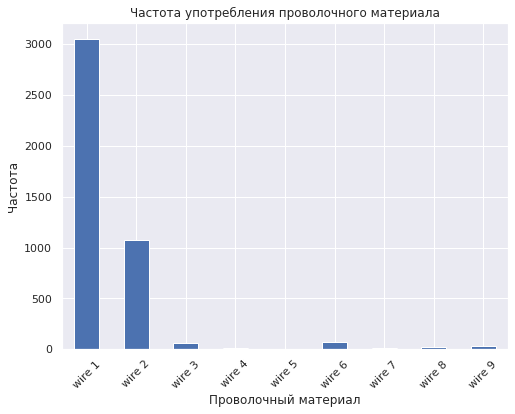

In [56]:
wire_material_usage = data_wire.loc[:, data_wire.columns != 'key'].astype(bool).sum()

plt.figure(figsize=(8, 6))
wire_material_usage.plot(kind='bar')
plt.xlabel('Проволочный материал')
plt.ylabel('Частота')
plt.title('Частота употребления проволочного материала')
plt.xticks(rotation=45)
plt.show()

Все провлончые материалы кроме 1 и 2 употреблялись крайне редко.

### data_wire_time

In [57]:
display(data_wire_time.info(), data_wire_time.describe(), data_wire_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire 1  3055 non-null   object
 2   wire 2  1079 non-null   object
 3   wire 3  63 non-null     object
 4   wire 4  14 non-null     object
 5   wire 5  1 non-null      object
 6   wire 6  73 non-null     object
 7   wire 7  11 non-null     object
 8   wire 8  19 non-null     object
 9   wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


In [58]:
wire_columns = [col for col in data_wire_time.columns if 'wire' in col]
data_wire_time[wire_columns].describe()

,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
count,3055,1079,63,14,1,73,11,19,29
unique,3000,1075,63,14,1,73,11,19,29
top,10:07:11,11:15:54,17:43:23,07:15:28,16:01:07,03:28:47,10:43:30,17:36:23,05:22:29
freq,2,2,1,1,1,1,1,1,1


Опять же, измерения адеквадные. Как их использовать я не совсем понимаю.

### Вывод по EDA

Был проведен исследовательский анализ данных для каждой таблицы. Были обработаны встреченные аномалии. Особенное внимание было уделено табличке с таргетом - неподходящие записи были устранены. Данные готовы к объединению и дальнейшей работе.

## Объединение данных

Будем собирать финальный датафрейм на основе `aggregated_data_temp`

In [59]:
final_df = aggregated_data_temp.copy()

In [60]:
final_df = final_df.merge(aggregated_data_arc, on='key', how='left')

In [61]:
final_df = final_df.merge(data_bulk, on='key', how='left')

In [62]:
final_df = final_df.merge(data_wire, on='key', how='left')

In [63]:
final_df = final_df.merge(data_gas, on='key', how='left')

In [64]:
final_df.head()

,key,initial_temperature,final_temperature,time_delta,arc_duration,apparent_power,power_ratio,heating_count,bulk 1,bulk 2,...,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9,gas
0,1,1571.0,1613.0,861.0,219.60,1.165279,1.538898,5,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,1305.0,202.75,0.912304,1.551834,4,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,1300.0,131.00,0.597907,1.583120,5,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,388.0,185.25,0.953741,1.563487,4,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,762.0,217.25,1.008939,1.480428,4,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


### Проверка данных на условия заказчика

Мы точно знаем, что во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался. Проведем проверку данных.

#### Проверка bulk

In [65]:
bulk_columns = [col for col in final_df.columns if 'bulk' in col]
bulk_check = final_df.groupby('key')[bulk_columns].apply(lambda x: (x != 0).any(axis=1).all())
bulk_all_true = bulk_check.all()
print("\nBulk check (хотя бы одно ненулевое значение для каждой партии):")
print(f"Check: {bulk_all_true}")


Bulk check (хотя бы одно ненулевое значение для каждой партии):
Check: True


#### Проверка wire

In [66]:
wire_columns = [col for col in final_df.columns if 'wire' in col]
wire_check = final_df.groupby('key')[wire_columns].apply(lambda x: (x != 0).any(axis=1).all())
wire_all_true = wire_check.all()
print("\nWire check (хотя бы одно ненулевое значение для каждой партии):")
print(f"Check: {wire_all_true}")


Wire check (хотя бы одно ненулевое значение для каждой партии):
Check: True


#### Проверка gas

In [67]:
gas_check = final_df.groupby('key')['gas'].apply(lambda x: (x != 0).all() and x.notna().all())
gas_all_true = gas_check.all()
print("\nGas check (проверка на NaN и 0):")
print(f"Check: {gas_all_true}")


Gas check (проверка на NaN и 0):
Check: False


In [68]:
failed_gas_keys = gas_check[~gas_check].index
print("\nФейл проверки (NaN или 0):")
final_df[final_df['key'].isin(failed_gas_keys)]


Фейл проверки (NaN или 0):


,key,initial_temperature,final_temperature,time_delta,arc_duration,apparent_power,power_ratio,heating_count,bulk 1,bulk 2,...,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9,gas
190,193,1593.0,1595.0,2487.0,173.333333,0.849979,1.383894,6,0.0,0.0,...,122.129272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
255,259,1577.0,1590.0,1080.0,179.250000,0.871509,1.233773,4,0.0,0.0,...,55.080479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [69]:
final_df = final_df[~final_df['key'].isin(failed_gas_keys)]

#### Проверка temp

In [70]:
has_nan_initial = final_df['initial_temperature'].isna().any()
has_nan_final = final_df['final_temperature'].isna().any()

has_zero_initial = (final_df['initial_temperature'] == 0).any()
has_zero_final = (final_df['final_temperature'] == 0).any()

if has_nan_initial or has_nan_final:
    print("Есть NaN значения в столбцах.")

if has_zero_initial or has_zero_final:
    print("Есть нулевые значения в столбцах.")

if not (has_nan_initial or has_nan_final or has_zero_initial or has_zero_final):
    print("В столбцах нет NaN и нулевых значений.")

В столбцах нет NaN и нулевых значений.


### EDA финальных данных

Заполняем все пропущенные до этого момента пропуски.

In [71]:
final_df = final_df.dropna()

In [72]:
display(final_df.info(), final_df.describe(), final_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2470
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2325 non-null   int64  
 1   initial_temperature  2325 non-null   float64
 2   final_temperature    2325 non-null   float64
 3   time_delta           2325 non-null   float64
 4   arc_duration         2325 non-null   float64
 5   apparent_power       2325 non-null   float64
 6   power_ratio          2325 non-null   float64
 7   heating_count        2325 non-null   int64  
 8   bulk 1               2325 non-null   float64
 9   bulk 2               2325 non-null   float64
 10  bulk 3               2325 non-null   float64
 11  bulk 4               2325 non-null   float64
 12  bulk 5               2325 non-null   float64
 13  bulk 6               2325 non-null   float64
 14  bulk 7               2325 non-null   float64
 15  bulk 8               2325 non-null   f

None

,key,initial_temperature,final_temperature,time_delta,arc_duration,apparent_power,power_ratio,heating_count,bulk 1,bulk 2,...,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9,gas
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,...,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,1587.365161,1593.366022,3796.627957,172.090653,0.836954,1.361381,4.696344,3.433548,1.424946,...,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658,11.378942
std,715.099053,23.623144,11.209581,12586.428317,43.751112,0.242401,0.131556,1.605930,12.421994,19.098442,...,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510,6.395632
min,1.000000,1519.000000,1541.000000,234.000000,57.000000,0.228541,0.687735,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399
25%,629.000000,1571.000000,1587.000000,1221.000000,141.000000,0.660435,1.294044,4.000000,0.000000,0.000000,...,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282948
50%,1255.000000,1587.000000,1593.000000,1651.000000,169.500000,0.816441,1.373487,5.000000,0.000000,0.000000,...,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100950
75%,1868.000000,1603.000000,1598.000000,2335.000000,198.750000,0.986631,1.441510,6.000000,0.000000,0.000000,...,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.217691
max,2499.000000,1660.000000,1653.000000,86192.000000,378.000000,1.796257,1.782164,16.000000,185.000000,325.000000,...,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,77.995040


,key,initial_temperature,final_temperature,time_delta,arc_duration,apparent_power,power_ratio,heating_count,bulk 1,bulk 2,...,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9,gas
0,1,1571.0,1613.0,861.0,219.60,1.165279,1.538898,5,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,1305.0,202.75,0.912304,1.551834,4,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,1300.0,131.00,0.597907,1.583120,5,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,388.0,185.25,0.953741,1.563487,4,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,762.0,217.25,1.008939,1.480428,4,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


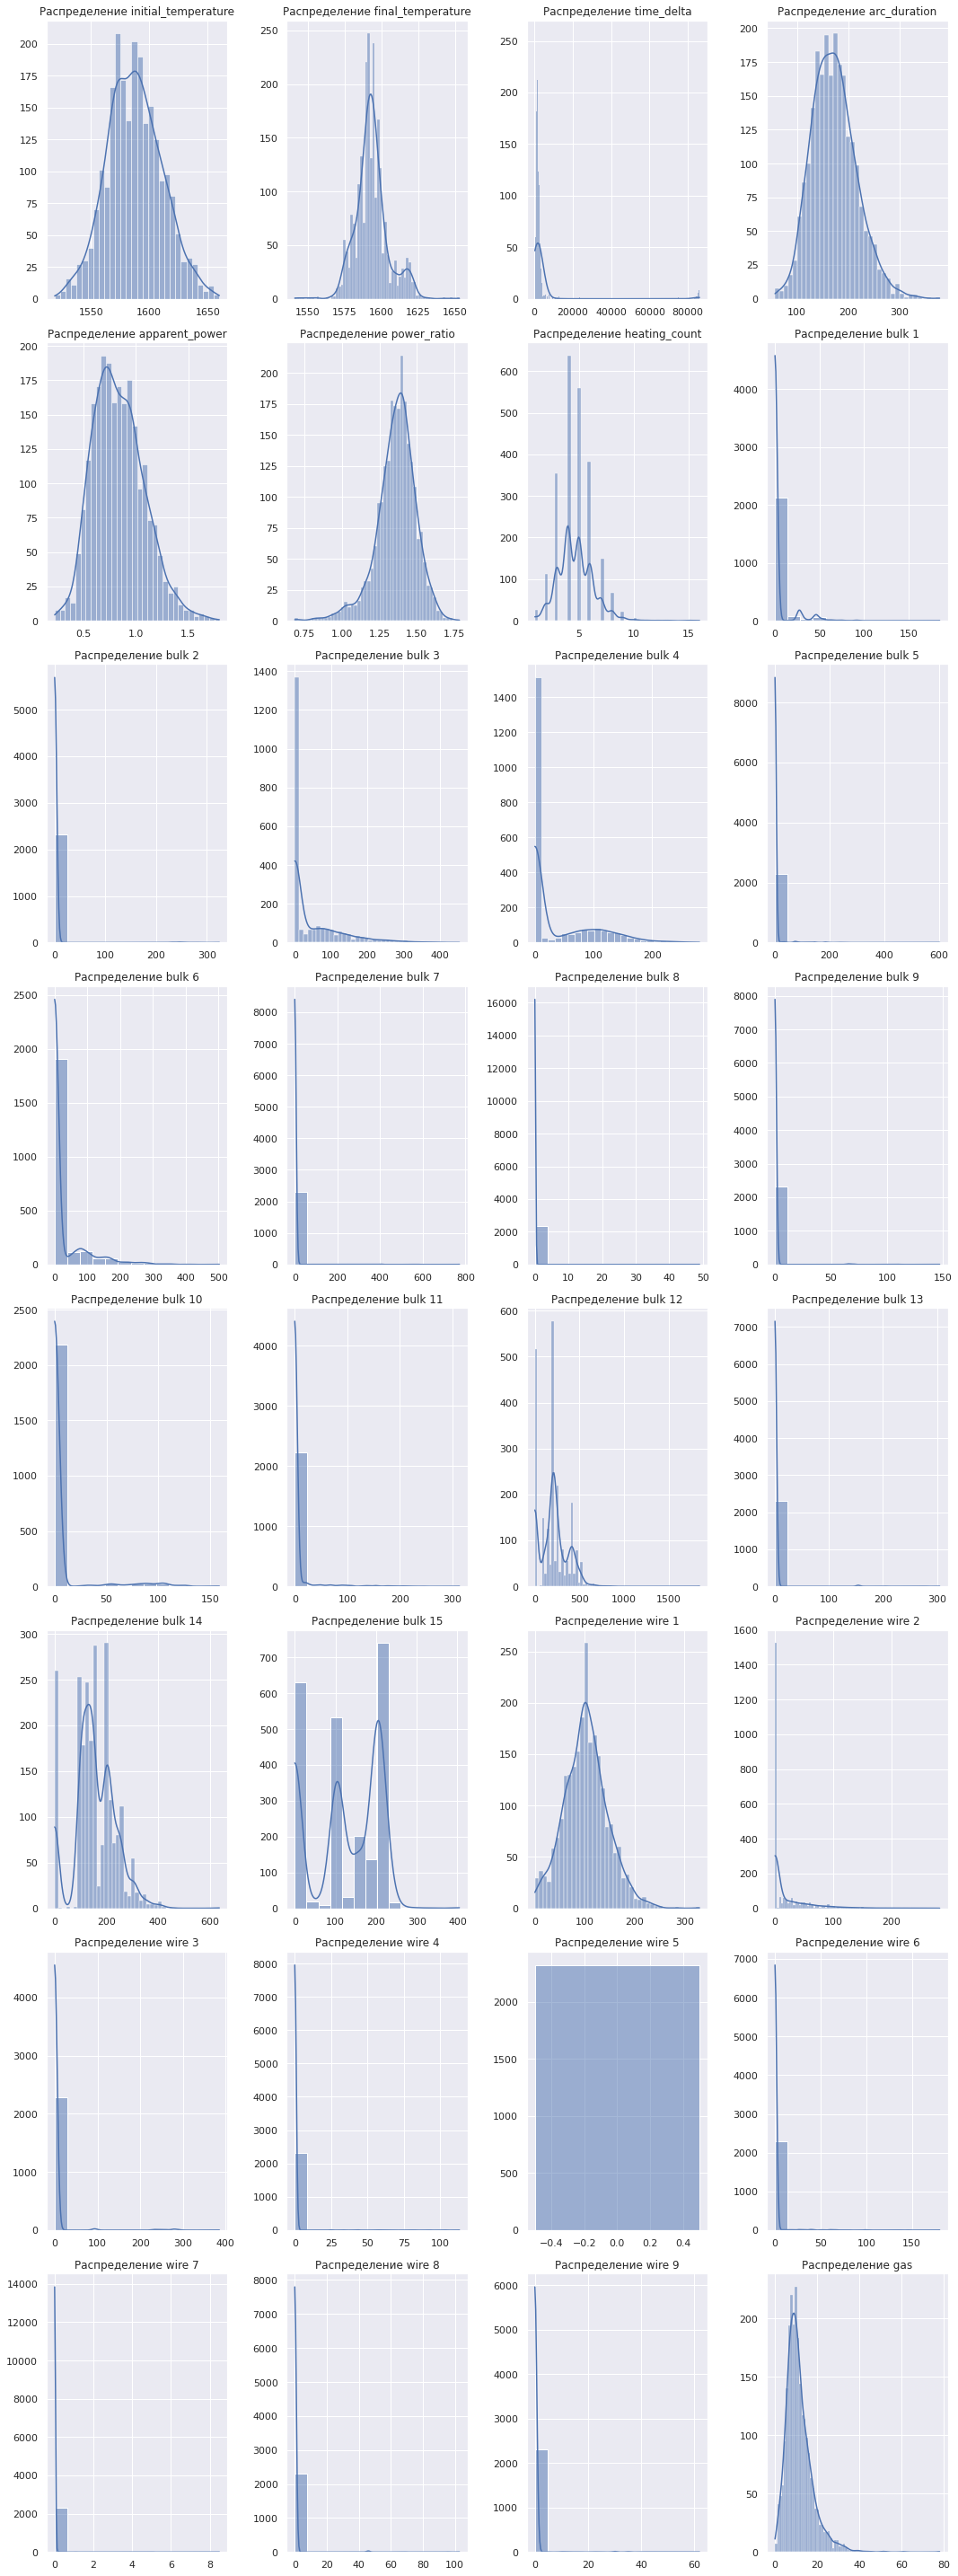

In [73]:
numeric_df = final_df.drop(columns=['key'])

num_features = len(numeric_df.columns)

num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, column in enumerate(numeric_df.columns):
    sns.histplot(numeric_df[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

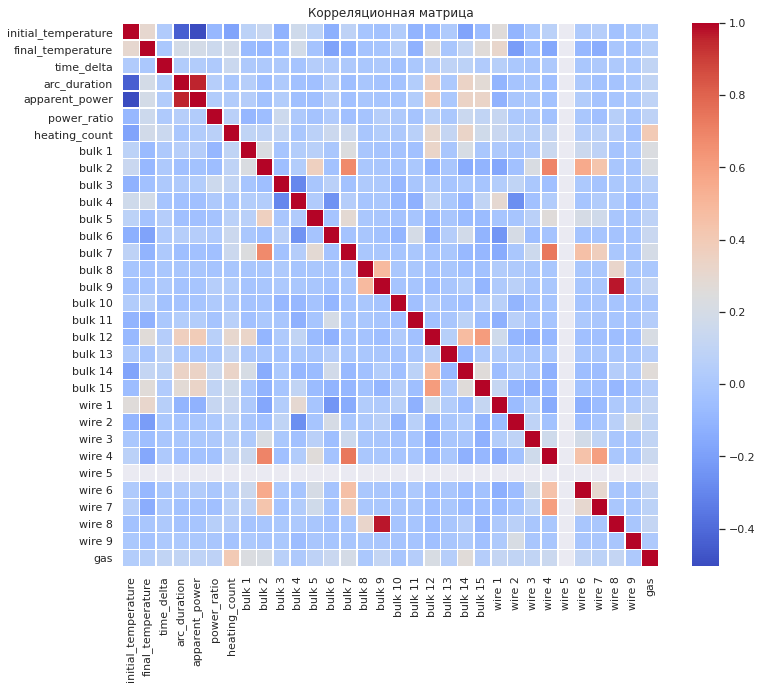

In [74]:
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

Видим корреляцию между arc_duration и total/apparent power. И некоторые интересные корреляции между bulk и wire materials, в частности wire 8/bulk 9.

## Подготовка данных для обучения

In [75]:
X = final_df.drop(['final_temperature', 'key'], axis = 1)
y = final_df['final_temperature']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [77]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1743, 31), (582, 31), (1743,), (582,))

## Модели

Заказчик рекомендует посмотреть такие классы моделей как:
* решающее дерево или случайный лес
* градиентный бустинг
* нейронные сети

Так и сделаем.

### decision tree

In [78]:
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),               
    ('regressor', DecisionTreeRegressor(random_state=RANDOM_STATE))  
])

In [79]:
param_grid_dt = {
    'regressor__max_depth': [None, 5, 10, 15],         
    'regressor__min_samples_split': [2, 3, 5, 10],           
    'regressor__min_samples_leaf': [1, 2, 3, 4],             
}

In [80]:
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=3, scoring='neg_mean_absolute_error')
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=220724))]),
             param_grid={'regressor__max_depth': [None, 5, 10, 15],
                         'regressor__min_samples_leaf': [1, 2, 3, 4],
                         'regressor__min_samples_split': [2, 3, 5, 10]},
             scoring='neg_mean_absolute_error')

In [81]:
best_params_dt = grid_search_dt.best_params_
best_model_dt = grid_search_dt.best_estimator_
print(f'Лучшие параметры для решающего дерева: {best_params_dt}')

mae_cv_dt = -grid_search_dt.best_score_
print(f'MAE на кросс-валидации для решающего дерева: {mae_cv_dt:.2f}')

Лучшие параметры для решающего дерева: {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10}
MAE на кросс-валидации для решающего дерева: 7.43


### random forest

In [82]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),              
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE))  
])

In [83]:
param_grid_rf = {
    'regressor__n_estimators': [200],    
    'regressor__max_depth': [None],  
    'regressor__min_samples_split': [2, 4],  
    'regressor__min_samples_leaf': [1, 2],
    'regressor__bootstrap': [True]          
}

In [84]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='neg_mean_absolute_error')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        RandomForestRegressor(random_state=220724))]),
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [None],
                         'regressor__min_samples_leaf': [1, 2],
                         'regressor__min_samples_split': [2, 4],
                         'regressor__n_estimators': [200]},
             scoring='neg_mean_absolute_error')

In [85]:
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_
print(f'Лучшие параметры для случайного леса: {best_params_rf}')

Лучшие параметры для случайного леса: {'regressor__bootstrap': True, 'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


In [86]:
mae_cv_rf = -grid_search_rf.best_score_
print(f'MAE на кросс-валидации для случайного леса: {mae_cv_rf:.2f}')

MAE на кросс-валидации для случайного леса: 6.46


### cb

In [87]:
pipeline_cb = Pipeline([
    ('scaler', StandardScaler()),            
    ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=0))  
])

In [88]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [89]:
param_grid_cb = {
    'regressor__learning_rate': [0.01, 0.1],           
    'regressor__depth': [4, 6],                         
    'regressor__iterations': [500, 1000],              
    'regressor__l2_leaf_reg': [1, 3],                    
}

In [90]:
grid_search_cb = GridSearchCV(pipeline_cb, param_grid_cb, cv=3, scoring=mae_scorer, n_jobs=-1)
grid_search_cb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        <catboost.core.CatBoostRegressor object at 0x7fbfc7a67490>)]),
             n_jobs=-1,
             param_grid={'regressor__depth': [4, 6],
                         'regressor__iterations': [500, 1000],
                         'regressor__l2_leaf_reg': [1, 3],
                         'regressor__learning_rate': [0.01, 0.1]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [91]:
best_params_cb = grid_search_cb.best_params_
best_model_cb = grid_search_cb.best_estimator_
print(f'Лучшие параметры для CatBoost: {best_params_cb}')

Лучшие параметры для CatBoost: {'regressor__depth': 4, 'regressor__iterations': 500, 'regressor__l2_leaf_reg': 3, 'regressor__learning_rate': 0.1}


In [92]:
mae_cv_cb = -grid_search_cb.best_score_
print(f'Sреднее значение MAE на кросс-валидации для CatBoost: {mae_cv_cb:.2f}')

Sреднее значение MAE на кросс-валидации для CatBoost: 5.84


### nn

In [93]:
class ImprovedNeuralNetwork(nn.Module):
    def __init__(self):
        super(ImprovedNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

In [94]:
X = X_train.values  
y = y_train.values  

In [95]:
k_folds = 3
num_epochs = 1500
batch_size = 128
learning_rate = 0.0005

In [96]:
kfold = KFold(n_splits=k_folds, shuffle=True)
fold_results = []

In [102]:
for fold, (train_ids, val_ids) in enumerate(kfold.split(X)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    X_train_fold, X_val_fold = X[train_ids], X[val_ids]
    y_train_fold, y_val_fold = y[train_ids], y[val_ids]
    
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)
    
    X_train_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = ImprovedNeuralNetwork()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()          
            outputs = model(inputs)      
            loss = criterion(outputs.squeeze(), targets)  
            loss.backward()              
            optimizer.step()              

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    model.eval()
    val_losses = []
    val_mae = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_losses.append(loss.item())
            mae = torch.mean(torch.abs(outputs.squeeze() - targets))
            val_mae.append(mae.item())
    
    avg_val_loss = np.mean(val_losses)
    avg_val_mae = np.mean(val_mae)
    fold_results.append(avg_val_mae)
    print(f'Validation Loss for fold {fold}: {avg_val_loss}\n')
    print(f'Validation MAE for fold {fold}: {avg_val_mae}\n')

FOLD 0
--------------------------------
Epoch [100/1500], Loss: 2445211.0000
Epoch [200/1500], Loss: 2264915.5000
Epoch [300/1500], Loss: 2012987.0000
Epoch [400/1500], Loss: 1716108.7500
Epoch [500/1500], Loss: 1395059.6250
Epoch [600/1500], Loss: 1092601.1250
Epoch [700/1500], Loss: 780336.6250
Epoch [800/1500], Loss: 510224.0000
Epoch [900/1500], Loss: 322149.8125
Epoch [1000/1500], Loss: 152906.7031
Epoch [1100/1500], Loss: 108318.1094
Epoch [1200/1500], Loss: 23463.7461
Epoch [1300/1500], Loss: 14860.0674
Epoch [1400/1500], Loss: 2520.7126
Epoch [1500/1500], Loss: 4083.8723
Validation Loss for fold 0: 564.7008483886718

Validation MAE for fold 0: 16.737423515319826

FOLD 1
--------------------------------
Epoch [100/1500], Loss: 2461717.5000
Epoch [200/1500], Loss: 2247905.0000
Epoch [300/1500], Loss: 1976350.7500
Epoch [400/1500], Loss: 1697156.3750
Epoch [500/1500], Loss: 1352167.7500
Epoch [600/1500], Loss: 1054567.6250
Epoch [700/1500], Loss: 747022.8750
Epoch [800/1500], Loss

In [104]:
avg_mae = np.mean(val_mae)
print(f'Average Validation MAE: {avg_mae}')

Average Validation MAE: 25.657820892333984


Мне кажется тут есть пространство для улучшения, сеть явно видит зависимость признака и таргета.

## Тестирование лучшей модели

Лучшей моделью оказался градиентный бустинг. Попробуем наткнуться на оптимальные параметры случайным поиском.

In [100]:
param_dist_cb = {
    'regressor__learning_rate': np.linspace(0.01, 0.2, 20),           
    'regressor__depth': [4, 5, 6, 7, 8],                         
    'regressor__iterations': [500, 1000, 1500],              
    'regressor__l2_leaf_reg': [1, 3, 5, 7],                    
    'regressor__bagging_temperature': np.linspace(0, 1, 10),
    'regressor__border_count': [32, 64, 128]
}

In [101]:
random_search_cb = RandomizedSearchCV(pipeline_cb, param_distributions=param_dist_cb, 
                                      n_iter=50, cv=5, scoring=mae_scorer, n_jobs=-1, random_state=RANDOM_STATE)
random_search_cb.fit(X_train, y_train)

best_params_cb = random_search_cb.best_params_
best_model_cb = random_search_cb.best_estimator_

print(f'Лучшие параметры для CatBoost: {best_params_cb}')

Лучшие параметры для CatBoost: {'regressor__learning_rate': 0.06999999999999999, 'regressor__l2_leaf_reg': 7, 'regressor__iterations': 1000, 'regressor__depth': 4, 'regressor__border_count': 128, 'regressor__bagging_temperature': 0.2222222222222222}


In [106]:
y_pred = best_model_cb.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f'MAE на тестовой выборке для CatBoost: {mae_test:.2f}')
print(f'R² на тестовой выборке для CatBoost: {r2_test:.2f}')

MAE на тестовой выборке для CatBoost: 5.50
R² на тестовой выборке для CatBoost: 0.57


Результаты улучшились. Приятно!

Посмотрим на feature importances

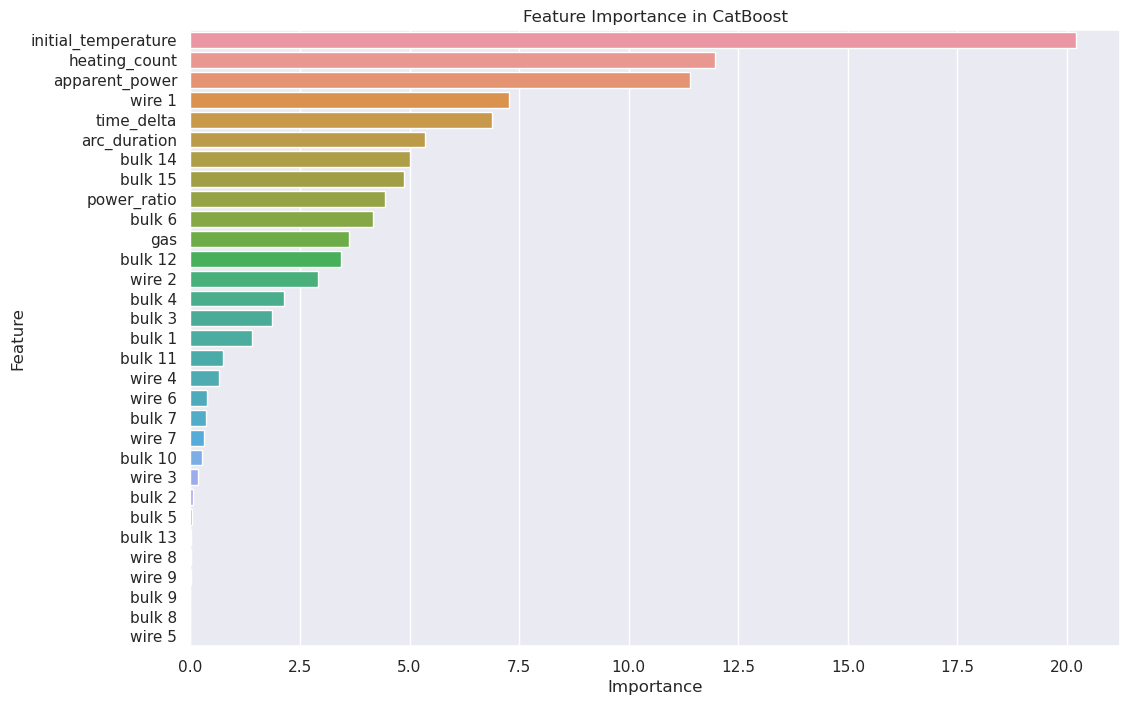

In [107]:
importances = best_model_cb.named_steps['regressor'].get_feature_importance()

feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in CatBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Как видим, самым важным признаком оказалась изначальная температура. Это ожидаемо - как мы видели на этапе EDA, финальная температура обычно была всего на несколько градусов выше изначальной. Наверное это особенность тех. процесса. Другими важными признаками оказались количество итераций, в которое проходило нагревание, количество проволочной добавки 1 (самой часто встречаемой), total и apparent power, time_delta -- время, истекшее между первым и последним нагревом, а также количество сыпучих добавок 14 и 15 (тоже соответствено самых частых в своих категориях). Ниже приведены графики зависимостей топ 5 фичей по важности с таргетом.

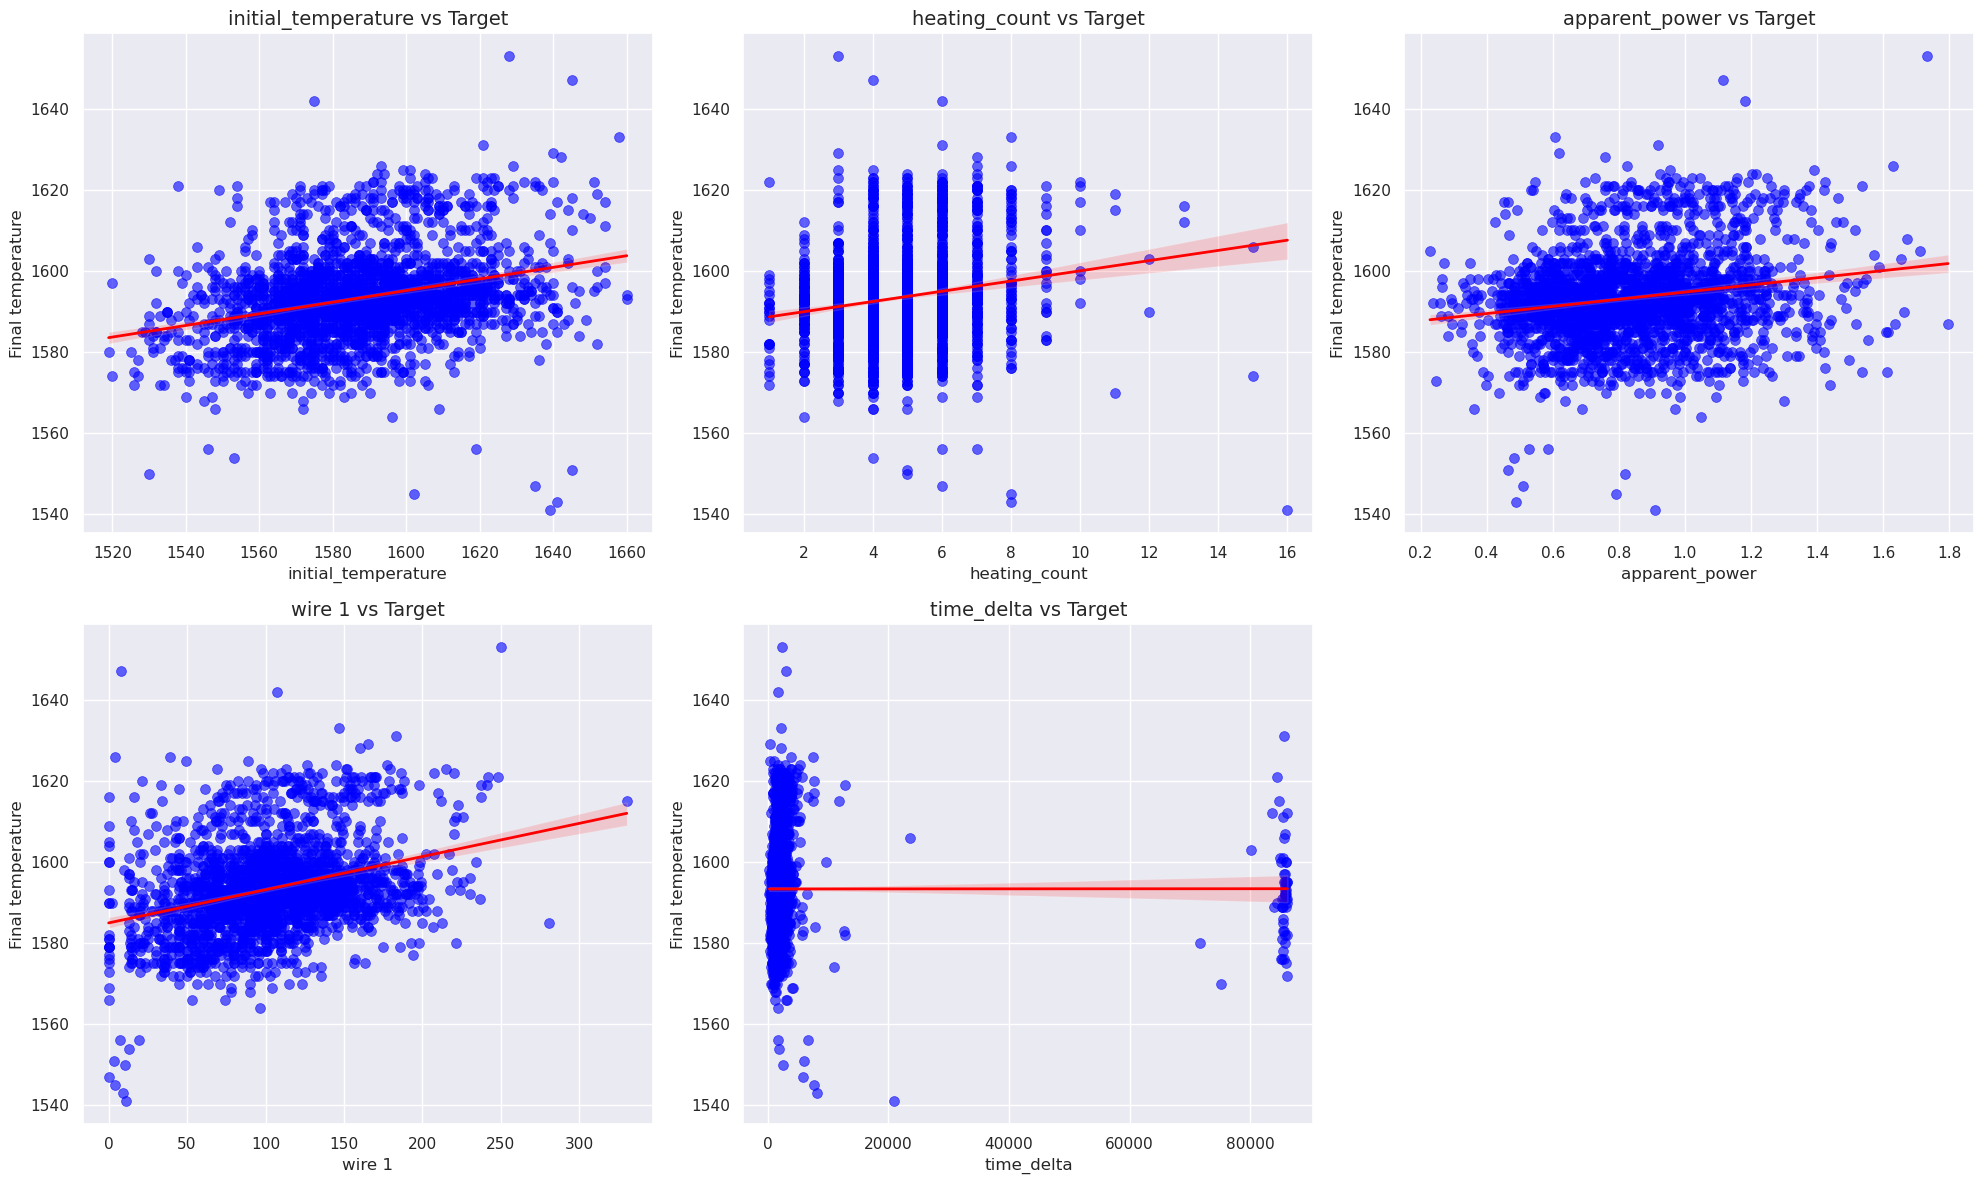

In [108]:
top_features = importance_df.head(5)['Feature'].tolist()

plt.figure(figsize=(20, 12))

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)  # Создание подграфиков
    sns.scatterplot(x=X[feature], y=y, color='blue', edgecolor=None, alpha=0.6, s=50)
    sns.regplot(x=X[feature], y=y, scatter=False, color='red', line_kws={'linewidth': 2})
    plt.title(f'{feature} vs Target', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Final temperature', fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()

Также сравним результаты нашей модели с константной.

In [109]:
mean_y_train = np.mean(y_train)
y_pred_const = np.full_like(y_test, mean_y_train)

mae_test_const = mean_absolute_error(y_test, y_pred_const)
print(f'MAE на тестовой выборке для константной модели: {mae_test_const:.2f}')

MAE на тестовой выборке для константной модели: 8.30


Модель работает лучше, чем константное предсказание, но не то чтобы сильно. Во время работы над разными моделями, у меня получались некоторые, предсказывающие сильно хуже чем это константное решение.

## Вывод

Была проведена большая работа над объединением данных, полученных от различной аппаратуры и сенсоров. В итоге был получен датафрейм, подходящий для моделирования.

Были протестированы следующие модели:
* решающий и случайный леса
* градиентный бустинг 
* нейросеть

Лучшие результаты показал градиентный бустинг, и с помощью грид- и рандомсерча для него был получен результат:
* MAE = 5.5 
* R² = 0.57 

На тестовой выборке. В то же время константная модель показывает результат в MAE = 8.3

Это указывает на то, что CatBoost смог извлечь и использовать более сложные зависимости.

В то же время я не слишком доволен результатами работы. Мне кажется, что задача предложенная заказчиком является одной из таких, которую невозможно решить с помощью усилий одного лишь машинного обучения. Здесь бы сильно пригодились знания профильного специалиста, работающего со сталью. Во время работы мне приходилось узнавать из специальной литературы, может ли тот или иной признак быть отрицательным, и как рассчитвается полная мощность, и я не совсем уверен, что могу правильно и в полной мере использовать эти знания. Исходя из всего этого я бы дал такие рекомендации заказчику:

* Составить команду, состоящую не только из дата сайентистов, но и профильных инженеров. Работая в тандеме можно сильно улучшить feature engineering как минимум
* В такой команде обратить внимание на feature importance. Мне например показалось интересным, что недостаток проволочного материала 1 в сырье и его последующее добавление приводит к более высокой температуре финального сплава. Так же можно посмотреть на зависимость количества итераций нагрева и фин. температуры
* Командой профессионалов изучить данные. Мне показались нормальными распределения и некоторые выбросы, которые я заметил. Вполне возможно что все не так просто.

Что касается улучшения самой модели:

* Из данных пришлось выкинуть около 23% наблюдений. Может быть если провести какую-нибудь толковую аугментацию, получатся данные, имитирующие настоящие
* Может быть стоит посмотреть в сторону ансамблей моделей
* Может быть из таблиц data_bulk_time и data_wire_time можно вытащить релевантные данные и построить какой-нибудь очень умный временной ряд
* Общего вида файнтюнинг